# `bindsnet` ETH replication

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

from timeit import default_timer

sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet', 'network')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'bindsnet', 'datasets')))

from datasets    import MNIST
from network     import Network
from encoding    import get_poisson
from connections import Connection, post_pre
from nodes       import AdaptiveLIFNodes, LIFNodes, IFNodes, Input

%matplotlib notebook

## Build network

In [2]:
network = Network(dt=1.0)

In [3]:
n = 100; n_sqrt = int(np.sqrt(n))

input_layer = Input(n=784, traces=True, trace_tc=1 / 20)
exc_layer = AdaptiveLIFNodes(n=n, traces=True, rest=-65.0, reset=-65.0, threshold=-52.0, refractory=5,
                                    voltage_decay=1e-2, trace_tc=1 / 20, theta_plus=0.05, theta_decay=1e-7)
inh_layer = LIFNodes(n=n, traces=False, rest=-60.0, reset=-45.0, threshold=-40.0,
                                 voltage_decay=1e-1, refractory=2, trace_tc=1 / 20)

w = 0.3 * torch.rand(input_layer.n, exc_layer.n)
input_exc_conn = Connection(source=input_layer, target=exc_layer, w=w,
                            update_rule=post_pre, wmin=0.0, wmax=1.0)

w = 22.5 * torch.diag(torch.ones(exc_layer.n))
exc_inh_conn = Connection(source=exc_layer, target=inh_layer, w=w, update_rule=None)

w = -17.5 * (torch.ones(inh_layer.n, exc_layer.n) - torch.diag(torch.ones(inh_layer.n)))
inh_exc_conn = Connection(source=inh_layer, target=exc_layer, w=w, update_rule=None)

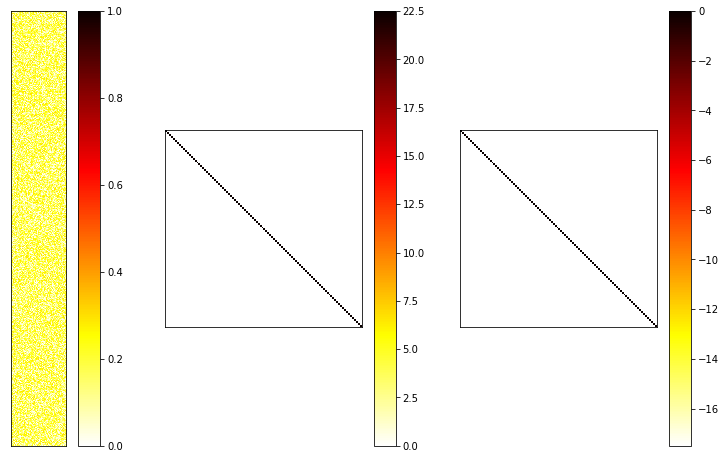

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

ims = []

ims.append(axes[0].matshow(input_exc_conn.w, cmap='hot_r', vmin=0, vmax=1))
ims.append(axes[1].matshow(exc_inh_conn.w, cmap='hot_r'))
ims.append(axes[2].matshow(inh_exc_conn.w, cmap='hot_r'))

for ax in axes:
    ax.set_xticks(()); ax.set_yticks(());

for ax, im in zip(axes, ims):
    plt.colorbar(im, ax=ax)

In [5]:
network.add_layer(input_layer, name='X')
network.add_layer(exc_layer, name='Ae')
network.add_layer(inh_layer, name='Ai')

network.add_connection(input_exc_conn, source='X', target='Ae')
network.add_connection(exc_inh_conn, source='Ae', target='Ai')
network.add_connection(inh_exc_conn, source='Ai', target='Ae')

## Load MNIST data

In [6]:
images, labels = MNIST(path='../../data').get_train()
images /= (255 * 10)

Loading training images from serialized object file.

Loading labels from serialized object file.



In [7]:
print('Training images shape', images.size())
print('Training labels shape', labels.size())

Training images shape torch.Size([60000, 28, 28])
Training labels shape torch.Size([60000])


## Encode MNIST images as Poisson spike trains

In [8]:
time = 350
data_loader = get_poisson(data=images, time=time)

## Train the network

In [9]:
plt.rcParams['figure.figsize'] = (10, 10)

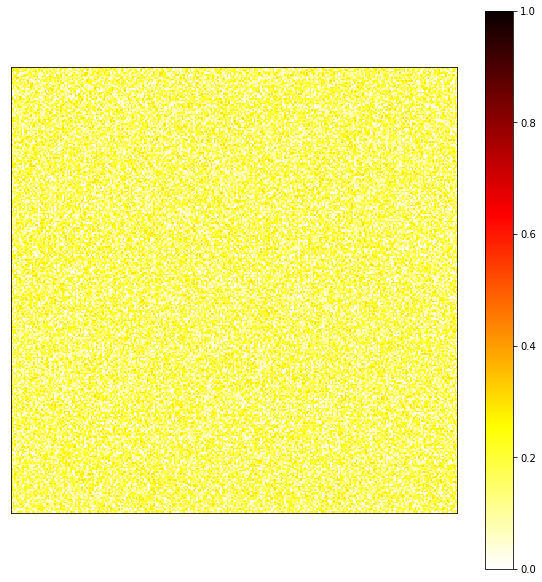

In [10]:
weights = network.connections[('X', 'Ae')].w

to_plot = np.zeros([28 * n_sqrt, 28 * n_sqrt])
for i in range(n_sqrt):
    for j in range(n_sqrt):
        filter_ = weights[:, i * n_sqrt + j].numpy().reshape([28, 28])
        to_plot[i * 28 : (i + 1) * 28, (j % n_sqrt) * 28 : ((j % n_sqrt) + 1) * 28] = filter_
                        
plt.matshow(to_plot, cmap='hot_r', vmin=0, vmax=1);
plt.xticks(()); plt.yticks(());
plt.colorbar();

In [11]:
n_train = 100
print_interval = 10

start = default_timer()

for i in range(n_train):    
    if i % print_interval == 0:
        print('Progress: %d / %d (%.4f seconds)' % (i, n_train, default_timer() - start))
        start = default_timer()
    
    sample = next(data_loader)
    inpts = {'X' : sample.view(time, -1)}
    
    spikes = network.run(inpts=inpts, time=time)
    network._reset()
    network.connections[('X', 'Ae')].normalize()

print('Progress: %d / %d (%.4f seconds)' % (n_train, n_train, default_timer() - start))

Progress: 0 / 100 (0.0002 seconds)
Progress: 10 / 100 (2.1542 seconds)
Progress: 20 / 100 (2.0978 seconds)
Progress: 30 / 100 (2.1580 seconds)
Progress: 40 / 100 (2.1375 seconds)
Progress: 50 / 100 (2.0498 seconds)
Progress: 60 / 100 (2.1222 seconds)
Progress: 70 / 100 (2.0842 seconds)
Progress: 80 / 100 (2.1938 seconds)
Progress: 90 / 100 (2.1074 seconds)
Progress: 100 / 100 (2.0508 seconds)


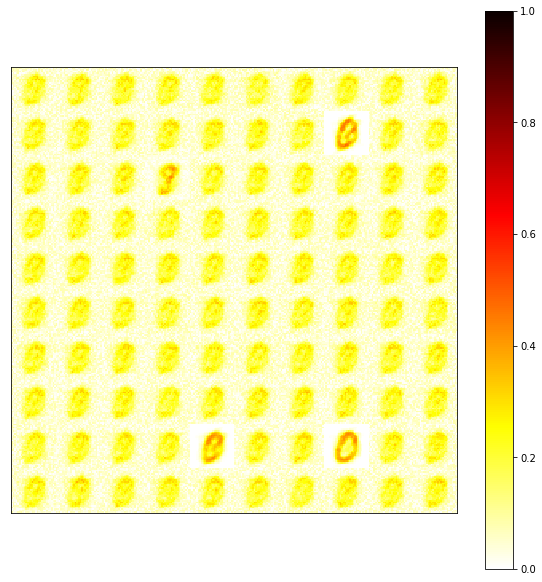

In [12]:
weights = network.connections[('X', 'Ae')].w

to_plot = np.zeros([28 * n_sqrt, 28 * n_sqrt])
for i in range(n_sqrt):
    for j in range(n_sqrt):
        filter_ = weights[:, i * n_sqrt + j].numpy().reshape([28, 28])
        to_plot[i * 28 : (i + 1) * 28, (j % n_sqrt) * 28 : ((j % n_sqrt) + 1) * 28] = filter_
                        
plt.matshow(to_plot, cmap='hot_r', vmin=0, vmax=1);
plt.xticks(()); plt.yticks(());
plt.colorbar();

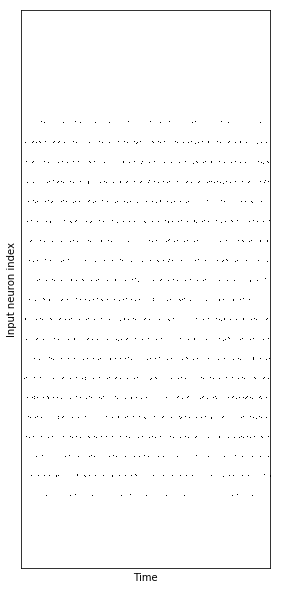

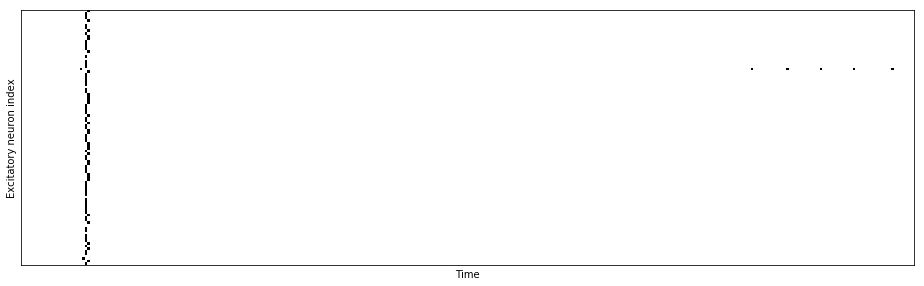

In [13]:
plt.matshow(spikes['X'], cmap='binary');
plt.xticks(()); plt.yticks(());
plt.xlabel('Time'), plt.ylabel('Input neuron index');

plt.matshow(spikes['Ae'], cmap='binary');
plt.xticks(()); plt.yticks(());
plt.xlabel('Time'), plt.ylabel('Excitatory neuron index');